Quickstart
==

This page demonstrates how to use the Python module `mushi` to infer demographic history and mutation spectrum history

We use `mushi` to infer effective population size history and history of the mutation process, which we can think of as the mutation rate function over time for each of many mutation types.
In `mushi`, we use coalescent theory and optimization techniques to learn about this history from the $k$-SFS: a matrix whose columns are sample frequency spectra (SFS) for each mutation type (or just the standard SFS if we are only interested in inferring demographic history).


## Imports
We first import the `mushi` package, and a few other standard packages.

In [1]:
import mushi

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/williamdewitt/Applications/miniconda2/envs/mushidocs/lib/python3.7/site-packages/traitlets/traitlets.py:3036: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,


## Reading sample frequency spectrum data

The most important class in the `mushi` package is the `kSFS`, which holds site frequency spectrum (SFS) data, or $k$-SFS data for multiple mutation types.
There are several ways to instantiate a `kSFS` object (for details read the API documentation):

### 1. From a `numpy` array

Here we demonstrate a `kSFS` instantiated from a numpy array, and then a plot of the resulting SFS.

/Users/williamdewitt/Applications/miniconda2/envs/mushidocs/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


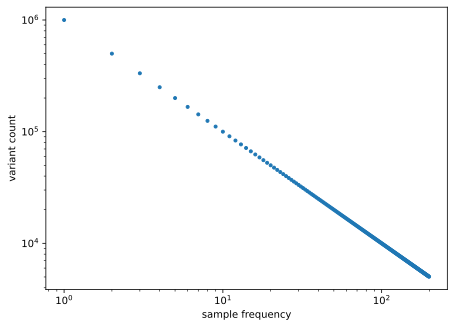

In [2]:
x = 1e6 / np.arange(1, 200)

ksfs = mushi.kSFS(X=x)

ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

### 2. From a tsv file

For example, suppose a file `ksfs.tsv` contains $k$-SFS data (in the format generated by the seperate `mutyper` package), or simply an SFS with sample frequencies in the first column and variant counts in the second. The `kSFS` is instantiated as

```python
ksfs = mushi.kSFS(file='ksfs.tsv')
```

### 3. By simulation

We can also instantiate by only specifying the number of number of sampled haplotypes $n$, then generating simulated SFS or $k$-SFS data by specifying a demographic history and a optionally a mutation spectrum history.
We will proceed with this approach for this demonstration.

In [3]:
ksfs = mushi.kSFS(n=200)

We now define a true demographic history for simulation (note that for inference on real data, this is not necessary).
In `mushi`, the demographic history is denoted by the haploid effective population size history $\eta(t)$ ("eta" of t), and can be constructed using the class `mushi.eta`.

**Note that for diploids, $\eta(t)=2N(t)$.**

We instantiate demographic history with a vector of times (into the past) when the population size changes, and a vector of population sizes in each interval.
Here we define a simple bottleneck history, and plot it.

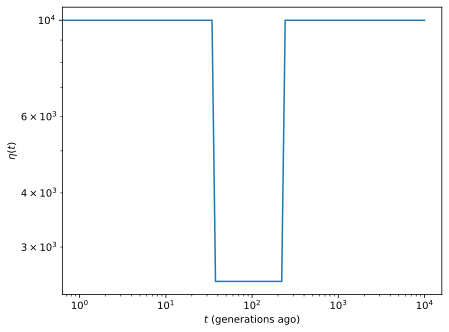

In [4]:
t = np.logspace(0, 4, 100)
y = 1e4 * np.ones(t.size + 1)
y[40:60] /= 4

eta_true = mushi.eta(t, y)

eta_true.plot()

Now we simulate SFS data using this demographic history.
We also specify a constant mutation rate (mutations per genome per generation), a rate of ancestral misidentification, and a random seed.

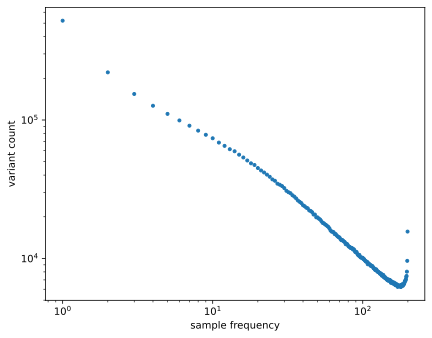

In [5]:
mu0 = 50
ksfs.simulate(eta_true, mu0, r=0.02, seed=1)

ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

## Demographic inference

With SFS data defined, we can attempt to infer demographic history, and ask if it resembles the true history we used to simulate the data.

Demographic inference requires an estimate of the total mutation rate, and optional regularization penalties.

### Regularization parameters

- The most important regularization parameter is the trend penalty, a tuple `(k, λ)`. This indicates a trend penalty of order `k` and strength `λ`. Inference will favor piece-wise polynomial solutions, with pieces of order `k`. For example using a 0th order penalty (as we do below) will favor piece-wise constant solutions. Using a 1st order penalty would allow linear pieces, and a 2nd order penalty would allow quadratic pieces, etc. Multiple trend penalty tuples can be supplied, which will result in solutions that are a mix of pieces of different orders.
- An additional `ridge_penalty` parameter improves convergence without noticably affecting the solution, so we recommend using a small one, typically `1e-4`.

We use a single 0th order trend penalty, to favor piecewise constant solutions. The choice of which trend orders to use is a model selection choice that should be judiciously chosen, possible based on domain knowledge about the population under study.

We also can specify the number of iterations (if we want more than the default), and a verbosity level to print info about progress.

In [6]:
ksfs.infer_eta(mu0,
               (0, 1e2),  # <-- trend penalty
               ridge_penalty = 1e-4,
               max_iter=300,
               verbose=True)

initial objective -4.249421e+07



maximum iteration 300 reached with relative change in objective function 2.5e-08


We can now plot the fit to the SFS, as well as the inferred history alongside the true history. The inferred history is contained in the attribute `eta` of the `kSFS` object.

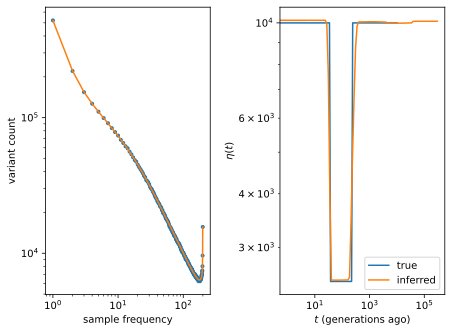

In [7]:
plt.subplot(121)
ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
eta_true.plot(label='true')
ksfs.eta.plot(label='inferred')
plt.legend();

The ancestral misidentification rate was also inferred (to fit the "smile"), and we can check that it is near the true value used to simulate.

In [8]:
ksfs.r

DeviceArray(0.02017785, dtype=float64)

### Folded SFS

For non-model organisms, it is often difficult to polarize the ancestral state of SNPs.
The SFS can be supplied with reference polarized data, and inference can be performed using the flag `folded=True`, to use the folded SFS (aggregating each sample frequence with its complement).
We can repeate the above inference using folded SFS inference to get similar results.

initial objective -4.442544e+07


iteration 113, objective -4.443e+07, relative change 1.088e-11


maximum iteration 300 reached with relative change in objective function 2.1e-11


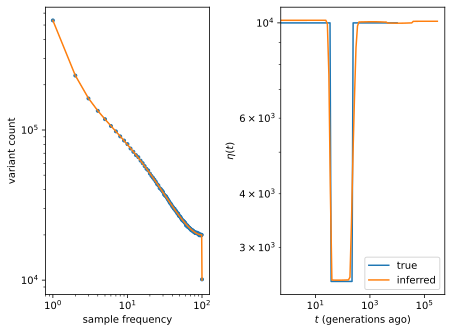

In [9]:
ksfs.infer_eta(mu0,
               (0, 1e2),
               ridge_penalty = 1e-4,
               folded=True,
               max_iter=300, verbose=True)

plt.subplot(121)
ksfs.plot_total(folded=True)
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
eta_true.plot(label='true')
ksfs.eta.plot(label='inferred')
plt.legend();

## Mutation spectrum history (mush) inference

We now consider data that is resolved into different mutation types (e.g. 96 triplet mutation types), and we have an SFS for each type as a separate column of a $k$-SFS matrix.
As described above, a `kSFS` can be instantiated from a numpy array, or loaded from a tsv file.
Here we'll again simulate one, so we first need to define a true mutation spectrum history.

In `mushi`, the mush is denoted by a time dependent mutation rate history vector $\boldsymbol\mu(t)$ ("mu" of t), and can be constructed using the class `mushi.mu`.
Each component of the vector is the mutation rate for one mutation type (e.g. one triplet type, like `AAA>ACA`).

We instantiate mush with a vector of times (into the past) when the mush changes, and a _matrix_ of mutation rate vectors in each interval.
Here we define a a 96 dimensional history where all are constant in time except two: a pulse and a monotonic ramp.
Here again, note that this step would not be necessary for inference on real data, but is needed for this demonstration.

To simplify things, we'll aggregate all the constant mutation types, so we have mutation types: `TCC>TTC`, `GAA>GGA`, and `None` (which will contain the remaining 94 mutation types.

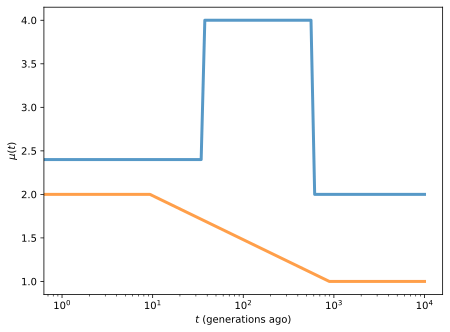

In [10]:
Z = np.ones((t.size + 1, 3))

# pulse
Z[40:70, 0] *= 2
Z[:40, 0] *= 1.2
Z[:, 0] *= 2

# ramp
Z[25:75, 1] *= np.linspace(2, 1, 50)
Z[:25, 1] *= 2

# flat
Z[:, 2] *= 94

# We model a TCC>TTC, it's revertant type GAA>GGA (for ancestral misidentification),
# and aggregate category for the remainder of mutations
mutation_types = ['TCC>TTC', 'GAA>GGA', None]

mu_true = mushi.mu(t, Z, mutation_types)

mu_true.plot(('TCC>TTC', 'GAA>GGA'), alpha=0.75, lw=3)

Now simulate new $k$-SFS data assuming this mush, and plot just the first two (non-constant) components.

Using the flag `clr=True` when plotting the $k$-SFS shows relative mutation counts (using a compositional transform) at each time, so it makes it easier to visualize.

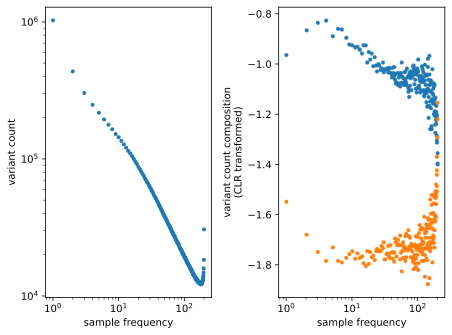

In [11]:
ksfs = mushi.kSFS(n=200)
ksfs.simulate(eta_true, mu_true, r=0.02, seed=1)

plt.subplot(121)
ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
ksfs.plot(('TCC>TTC', 'GAA>GGA'), clr=True)

initial objective -8.880823e+07



maximum iteration 300 reached with relative change in objective function 1.5e-08


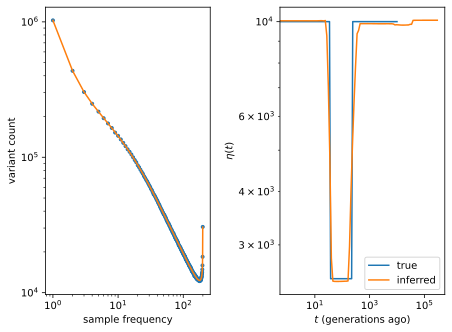

In [12]:
mu0 = Z[0, :].sum()

ksfs.infer_eta(mu0,
               (0, 1e2),
               ridge_penalty = 1e-4,
               max_iter=300, verbose=True)

plt.subplot(121)
ksfs.plot_total()
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
eta_true.plot(label='true')
ksfs.eta.plot(label='inferred')
plt.legend();

initial objective -8.770428e+07



maximum iteration 300 reached with relative change in objective function 3.6e-09


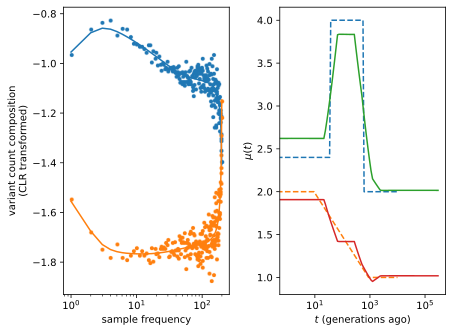

In [13]:
ksfs.infer_mush((0, 1e2), (1, 1e0), # <-- mixed trend penalties
                ridge_penalty = 1e-4,
                max_iter=300, verbose=True)

plt.subplot(121)
ksfs.plot(('TCC>TTC', 'GAA>GGA'), clr=True)

plt.subplot(122)
mu_true.plot(('TCC>TTC', 'GAA>GGA'), ls='--')
ksfs.mu.plot(('TCC>TTC', 'GAA>GGA'))